# Task 1

![](ex1.jpeg)

![](ex2,3.jpeg)

## Task 2

### Importaciones

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Cargar imágenes en gris

In [5]:
img1 = cv.imread("./img1.jpeg", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("./img2.jpeg", cv.IMREAD_GRAYSCALE)

assert img1 is not None and img2 is not None, "Error cargando imágenes"

### SIFT: detección y descripción

In [6]:
sift = cv.SIFT_create()

kp1_sift, des1_sift = sift.detectAndCompute(img1, None)
kp2_sift, des2_sift = sift.detectAndCompute(img2, None)

### ORB: detección y descripción

In [7]:
orb = cv.ORB_create(nfeatures=2000)

kp1_orb, des1_orb = orb.detectAndCompute(img1, None)
kp2_orb, des2_orb = orb.detectAndCompute(img2, None)

### Matching (Brute Force)

### BFMatcher para SIFT (L2)

In [8]:
bf_sift = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
matches_sift = bf_sift.knnMatch(des1_sift, des2_sift, k=2)

### BFMatcher para ORB (Hamming)

In [9]:
bf_orb = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=False)
matches_orb = bf_orb.knnMatch(des1_orb, des2_orb, k=2)

### Lowe’s Ratio Test (CRÍTICO)

In [10]:
def ratio_test(matches, ratio=0.75):
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

good_sift = ratio_test(matches_sift)
good_orb = ratio_test(matches_orb)

### Visualización de matches

### SIFT

In [11]:
img_sift_matches = cv.drawMatches(
    img1, kp1_sift,
    img2, kp2_sift,
    good_sift, None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

### ORB

In [12]:
img_orb_matches = cv.drawMatches(
    img1, kp1_orb,
    img2, kp2_orb,
    good_orb, None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

In [13]:
print(type(good_sift), len(good_sift) if good_sift is not None else "None")
print(type(good_orb), len(good_orb) if good_orb is not None else "None")

<class 'list'> 148
<class 'list'> 11


### Mostrar resultados

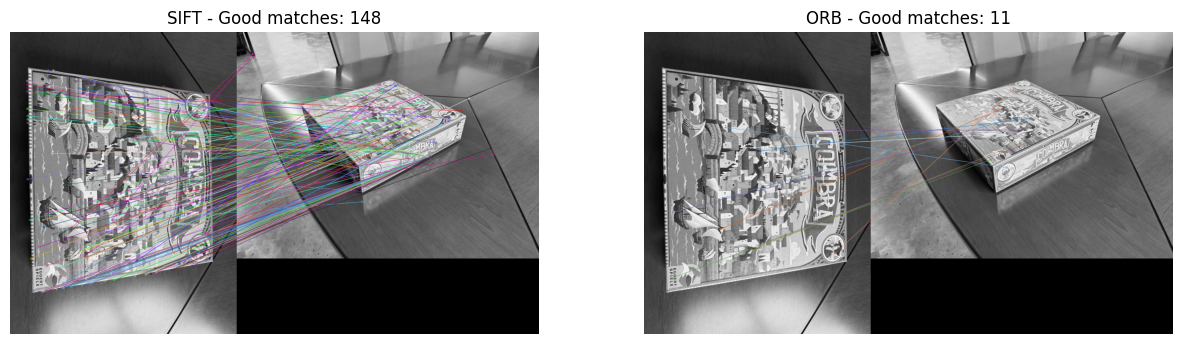

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title(f"SIFT - Good matches: {len(good_sift)}")
plt.imshow(img_sift_matches, cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.title(f"ORB - Good matches: {len(good_orb)}")
plt.imshow(img_orb_matches, cmap='gray')
plt.axis("off")

plt.show()

# Task 3

In [16]:
import time

def benchmark_algorithm(name, detector, matcher, img1, img2):
    start_det = time.time()
    kp1, des1 = detector.detectAndCompute(img1, None)
    kp2, des2 = detector.detectAndCompute(img2, None)
    end_det = time.time()
    t_det_desc = (end_det - start_det) * 1000 / 2 

    start_match = time.time()
    matches = matcher.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    end_match = time.time()
    t_match = (end_match - start_match) * 1000

    return {
        "Algoritmo": name,
        "T. Det+Desc (ms)": round(t_det_desc, 2),
        "T. Match (ms)": round(t_match, 2),
        "T. Total (ms)": round(t_det_desc * 2 + t_match, 2),
        "Keypoints (A/B)": f"{len(kp1)} / {len(kp2)}",
        "Buenos Matches": len(good_matches)
    }

results_sift = benchmark_algorithm("SIFT", sift, bf_sift, img1, img2)
results_orb = benchmark_algorithm("ORB", orb, bf_orb, img1, img2)

df = pd.DataFrame([results_sift, results_orb])
print(df.to_string(index=False))

Algoritmo  T. Det+Desc (ms)  T. Match (ms)  T. Total (ms) Keypoints (A/B)  Buenos Matches
     SIFT            213.80          63.88         491.49     4721 / 2106             148
      ORB             19.56           7.53          46.64     2000 / 2000              11


a. ¿Cuál algoritmo elegiría para el Producto A (Drone de Carreras) y por qué?

Para el Producto A el algoritmo que elegiria es ORB aunque el tiempo total medido es de 46.64 ms es mas rapido que SIFT, que tarda 491.49 ms. En un entorno de carreras a 80km/h la baja latencia es vital para el funcionamiento del drone SIFT causaría un retraso de casi medio segundo por frame haciendo imposible la navegación en tiempo real.

b. ¿Cuál algoritmo elegirías para el Producto B (Inspección) y por qué?

Para el Producto B, el algoritmo ganador es SIFT ya que los tests muestran que SIFT obtuvo 148 buenos matches frente a los escasos 11 de ORB donde en una inspeccion de grietas donde se busca precision milimetrica y se trabaja con imagenes de alta resolución para stitching, la robustez de SIFT ante los cambios de escala y rotación justifica totalmente el tiempo de procesamiento extra. Como el drone vuela estático no hay necesidad de procesar cada frame instantaneamente.

c. ¿Las conclusiones son justas y generalizables? ¿Por qué? ¿Qué considerar a futuro?

Sí, las conclusiones son justas para los escenarios planteados, ya que reflejan el balance clasico entre velocidad y precision, sin embargo para que sean totalmente generalizables a futuro se debería considerar:

- Optimización de Hardware: El uso de aceleración por GPU o procesadores específicos (NPU) que podrían bajar el tiempo de SIFT.

- Calidad de Imagen: Evaluar como afecta el desenfoque de movimiento real del drone a la deteccion de puntos clave en ambos algoritmos.

- Deep Learning: Probar descriptores modernos basados en redes neuronales que intentan combinar lo mejor de ambos mundos.